# Mismatch Report Generator

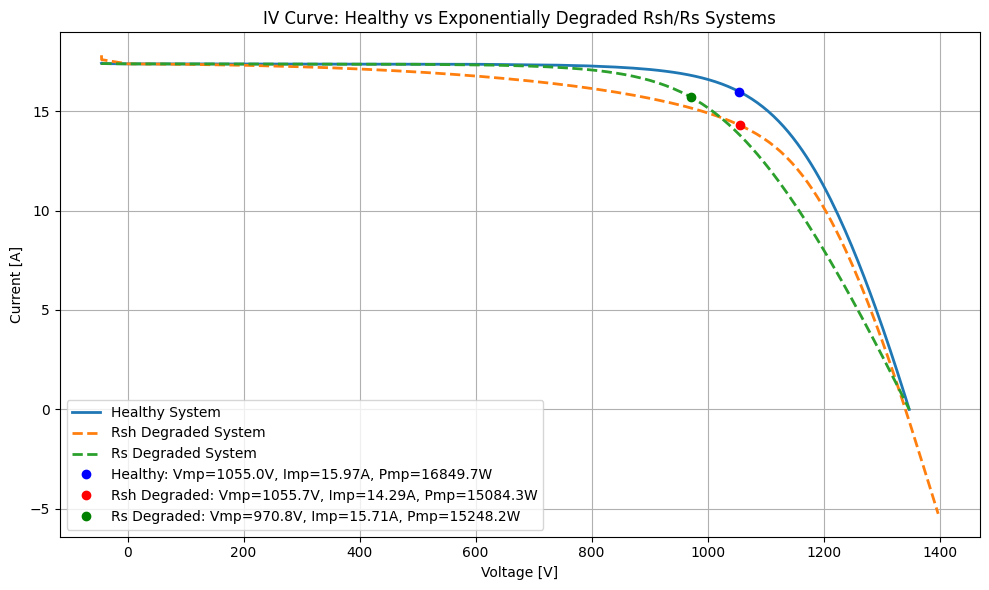

Healthy Pmp: 16849.723929502612
Rsh Degraded Pmp: 15084.32082027392
Rs Degraded Pmp: 15248.233127430683


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from simulation import pvsys_healthy, pvsys_Rsh_degraded, pvsys_Rs_degraded

### Mismatch Report Calculations

In [2]:
def mpp_from_curve(I, V, P):
    k = np.argmax(P)
    return P[k].squeeze().item(), I[k].squeeze().item(), V[k].squeeze().item()

def mismatch_report(pvsys, pvsys_healthy=None):
    """
    Reports degradation-only vs mismatch-only losses at the module, string, and system levels.
    """

    # --- actual system degraded MPP (with mismatch) ---
    Pmp_sys, _, _ = mpp_from_curve(pvsys.Isys, pvsys.Vsys, pvsys.Psys)

    # --- per-string degraded (with mismatch inside strings) ---
    Pmp_str = []
    for pvstr in pvsys.pvstrs:
        Pmp_s, _, _ = mpp_from_curve(pvstr.Istring, pvstr.Vstring, pvstr.Pstring)
        Pmp_str.append(Pmp_s)
    Pmp_str_sum = float(np.sum(Pmp_str))

    # --- per-module degraded (isolated, no mismatch inside strings) ---
    Pmp_mod = []
    for pvstr in pvsys.pvstrs:
        for mod in pvstr.pvmods:
            Pmp_m, _, _ = mpp_from_curve(mod.Imod, mod.Vmod, mod.Pmod)
            Pmp_mod.append(Pmp_m)
    Pmp_mod_sum = float(np.sum(Pmp_mod))

    # --- healthy baseline (if provided) ---
    Pmp_mod_healthy_sum = None
    Pmp_str_healthy_sum = None
    Pmp_sys_healthy = None
    if pvsys_healthy is not None:
        # Healthy modules
        Pmp_mod_healthy = []
        for pvstr in pvsys_healthy.pvstrs:
            for mod in pvstr.pvmods:
                Pmp_m, _, _ = mpp_from_curve(mod.Imod, mod.Vmod, mod.Pmod)
                Pmp_mod_healthy.append(Pmp_m)
        Pmp_mod_healthy_sum = float(np.sum(Pmp_mod_healthy))

        # Healthy strings
        Pmp_str_healthy = []
        for pvstr in pvsys_healthy.pvstrs:
            Pmp_s, _, _ = mpp_from_curve(pvstr.Istring, pvstr.Vstring, pvstr.Pstring)
            Pmp_str_healthy.append(Pmp_s)
        Pmp_str_healthy_sum = float(np.sum(Pmp_str_healthy))

        # Healthy system
        Pmp_sys_healthy, _, _ = mpp_from_curve(pvsys_healthy.Isys,
                                               pvsys_healthy.Vsys,
                                               pvsys_healthy.Psys)

    # --- Loss decomposition ---
    losses = {}

    # Module >> String mismatch
    L_mismatch_mod_to_str = Pmp_mod_sum - Pmp_str_sum
    L_degradation_mods = (Pmp_mod_healthy_sum - Pmp_mod_sum) if Pmp_mod_healthy_sum else None

    # String >> System mismatch
    L_mismatch_str_to_sys = Pmp_str_sum - Pmp_sys
    L_degradation_strs = (Pmp_str_healthy_sum - Pmp_str_sum) if Pmp_str_healthy_sum else None

    # Total system
    L_total_mismatch = L_mismatch_mod_to_str + L_mismatch_str_to_sys
    L_total_degradation = (Pmp_sys_healthy - Pmp_mod_sum) - L_total_mismatch if Pmp_sys_healthy else None
    L_total = (Pmp_sys_healthy - Pmp_sys) if Pmp_sys_healthy else None

    losses.update({
        "Pmp_system_degraded": Pmp_sys,
        "Pmp_strings_sum": Pmp_str_sum,
        "Pmp_modules_sum": Pmp_mod_sum,
        "Pmp_modules_healthy_sum": Pmp_mod_healthy_sum,

        # Mismatch components
        "  Mismatch Components": "",
        "Mismatch_mod_to_str": L_mismatch_mod_to_str,
        "Mismatch_str_to_sys": L_mismatch_str_to_sys,
        "Mismatch_total": L_total_mismatch,

        # Degradation components
        "  Degradation Components": "",
        "Degradation_mods_only": L_degradation_mods,
        "Degradation_strs_only": L_degradation_strs,
        "Degradation_total": L_total_degradation,

        # Total system loss
        "  Total System Loss": "",
        "Loss_total": L_total,

        # Percentages (relative to healthy)
        "  Percentages": "",
        "Percent_mismatch": 100.0 * L_total_mismatch / Pmp_sys_healthy if Pmp_sys_healthy else None,
        "Percent_degradation": 100.0 * L_total_degradation / Pmp_sys_healthy if (Pmp_sys_healthy and L_total_degradation) else None,
        "Percent_total": 100.0 * L_total / Pmp_sys_healthy if Pmp_sys_healthy else None,
    })

    return losses

### Plot Function

In [3]:
def plot_mismatch_report(report, show_values=True):
    """
    Plot stacked bar chart of module >> string and string >> system levels
    showing production, mismatch losses and degradation losses.

    Parameters
    ----------
    report : dict
        Output from mismatch_report function.
    show_values : bool
        Whether to annotate bar values and percentages.
    """

    # Levels
    levels = ["Module >> String", "String >> System"]

    # Healthy module sum for reference
    healthy_total = report["Pmp_modules_healthy_sum"]

    # Calculate level components
    production = np.array([
        report["Pmp_modules_sum"],  # Module level
        report["Pmp_strings_sum"],  # String level
    ])

    mismatch = np.array([
        report["Mismatch_mod_to_str"],  # Module >> String
        report["Mismatch_str_to_sys"],  # String >> System
    ])

    degradation = np.array([
        report["Degradation_mods_only"],  # Module level
        report["Degradation_strs_only"],  # String >> System
    ])

    # Heights for stacking
    bottoms_mismatch = production
    bottoms_degradation = production + mismatch

    # Colour palette
    colours = {
        "production": "tab:blue",  # blue
        "mismatch": "tab:orange",  # orange
        "degradation": "tab:red",  # red
    }

    # Plot
    fig, ax = plt.subplots(figsize=(11, 7))
    bar_width = 0.6

    ax.bar(levels, production, bar_width, label="Production", color=colours["production"])
    ax.bar(levels, mismatch, bar_width, bottom=bottoms_mismatch, label="Mismatch Loss", color=colours["mismatch"])
    ax.bar(levels, degradation, bar_width, bottom=bottoms_degradation, label="Degradation Loss",
           color=colours["degradation"])

    # Annotate values and percentages
    if show_values:
        for i, (prod, mm, deg) in enumerate(zip(production, mismatch, degradation)):
            total = prod + mm + deg
            # font style
            ax.text(i, prod / 2, f"{prod:.0f}", ha='center', va='center', color='white', fontsize=10,
                    fontweight='medium')
            ax.text(i, prod + mm / 2, f"{mm:.0f}", ha='center', va='center', color='white', fontsize=10,
                    fontweight='medium')
            ax.text(i, prod + mm + deg / 2, f"{deg:.0f}", ha='center', va='center', color='white', fontsize=10,
                    fontweight='medium')
            # relative percentage vs healthy
            ax.text(i, total + 50, f"{100 * total / healthy_total:.1f}%", ha='center', va='bottom', fontsize=10,
                    fontweight='medium', color='gray')

    ax.set_ylabel("Power [W]", fontsize=12)
    ax.set_title("PV System Production, Mismatch, and Degradation", fontsize=13, fontweight='medium')
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

### Run and Plot Report for Rsh Degradation

Pmp_system_degraded      : 15085.09102574643
Pmp_strings_sum          : 15087.501913803468
Pmp_modules_sum          : 15557.317614381176
Pmp_modules_healthy_sum  : 16854.05523414129
  Mismatch Components    : 
Mismatch_mod_to_str      : 469.8157005777084
Mismatch_str_to_sys      : 2.4108880570383917
Mismatch_total           : 472.2265886347468
  Degradation Components : 
Degradation_mods_only    : 1296.7376197601152
Degradation_strs_only    : 1766.553332200123
Degradation_total        : 824.5485974259991
  Total System Loss      : 
Loss_total               : 1769.0017746954927
  Percentages            : 
Percent_mismatch         : 2.801851124388996
Percent_degradation      : 4.892275171312567
Percent_total            : 10.49597742009056


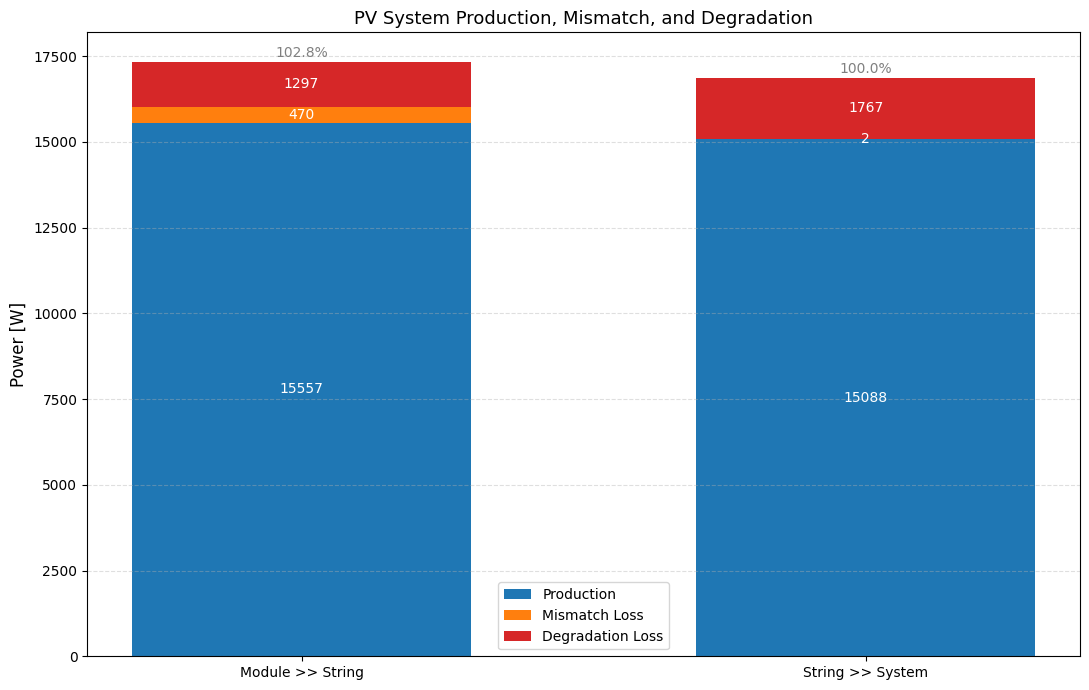

In [4]:
# Run report
report = mismatch_report(pvsys_Rsh_degraded, pvsys_healthy)

# Print outputs
for k, v in report.items():
    print(f"{k:25s}: {v}")

# Plot outputs
plot_mismatch_report(report)

### Run and Plot Report for Rs Degradation

Pmp_system_degraded      : 15250.291855768659
Pmp_strings_sum          : 15252.040470216925
Pmp_modules_sum          : 15256.639185830209
Pmp_modules_healthy_sum  : 16854.05523414129
  Mismatch Components    : 
Mismatch_mod_to_str      : 4.598715613283275
Mismatch_str_to_sys      : 1.7486144482663804
Mismatch_total           : 6.3473300615496555
  Degradation Components : 
Degradation_mods_only    : 1597.4160483110827
Degradation_strs_only    : 1602.0147757866653
Degradation_total        : 1591.1062845501638
  Total System Loss      : 
Loss_total               : 1603.800944673263
  Percentages            : 
Percent_mismatch         : 0.037660467025452865
Percent_degradation      : 9.44047421234351
Percent_total            : 9.515795146394415


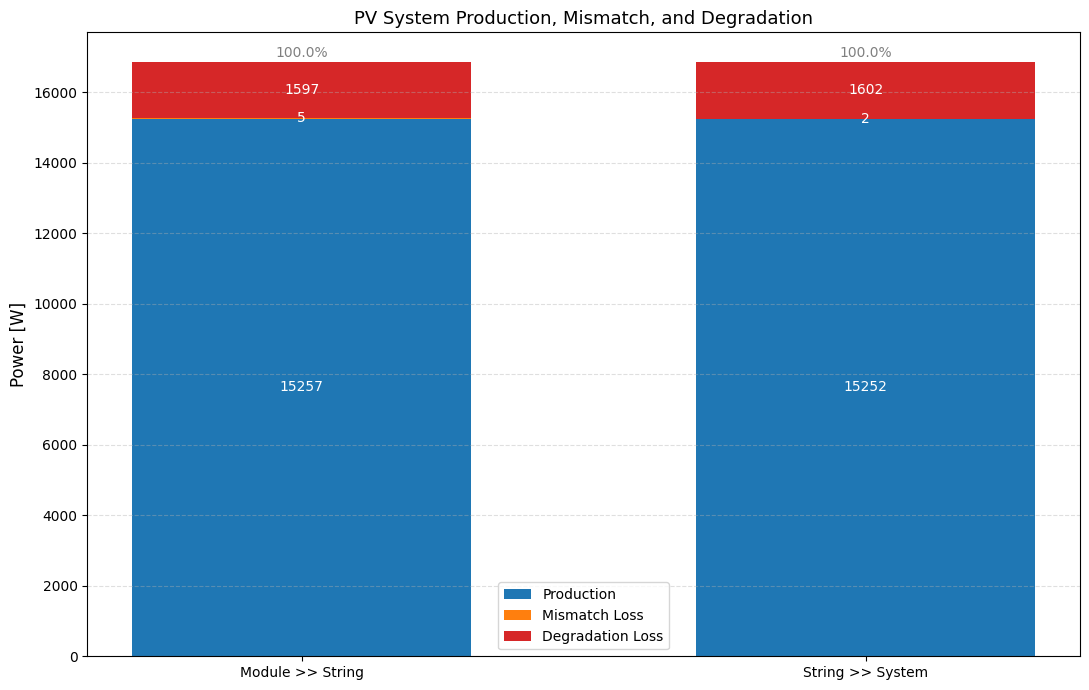

In [5]:
# Run report
report = mismatch_report(pvsys_Rs_degraded, pvsys_healthy)

# Print outputs
for k, v in report.items():
    print(f"{k:25s}: {v}")

# Plot outputs
plot_mismatch_report(report)